In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
import psutil

In [6]:
# Definir un bloque convolucional separable (depthwise separable convolution)
def conv_block(inputs, filters, kernel_size, strides, activation=True):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.Activation('swish')(x) # EfficientNet utiliza 'swish' como función de activación
    return x

# Definir un bloque de convolución separable (Depthwise Separable Convolution)
def depthwise_conv_block(inputs, pointwise_filters, kernel_size, strides):
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    # Convolución Pointwise
    x = layers.Conv2D(pointwise_filters, (1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    return x

# Definir la arquitectura de EfficientNet
def create_efficientnet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Primera capa convolucional
    x = conv_block(inputs, filters=32, kernel_size=(3, 3), strides=2) # Reduce el tamaño de la imagen

    # Bloques convolucionales separables en profundidad
    x = depthwise_conv_block(x, pointwise_filters=64, kernel_size=(3, 3), strides=1)
    x = depthwise_conv_block(x, pointwise_filters=128, kernel_size=(3, 3), strides=2)
    x = depthwise_conv_block(x, pointwise_filters=256, kernel_size=(3, 3), strides=2)
    
    # Añadir más bloques para aumentar la complejidad
    x = depthwise_conv_block(x, pointwise_filters=256, kernel_size=(3, 3), strides=1)
    x = depthwise_conv_block(x, pointwise_filters=512, kernel_size=(3, 3), strides=2)

    # Aplanar la salida y agregar capas densas
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='swish')(x)

    # Capa de salida con 10 unidades (una para cada clase de Fashion MNIST)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Cargar los datos de Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalizar las imágenes (dividir por 255 para que los valores estén entre 0 y 1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Añadir una dimensión extra para representar el canal (Fashion MNIST es en escala de grises, así que solo tiene un canal)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Convertir las etiquetas a una representación categórica
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)
datagen.fit(x_train)


In [7]:
# Crear el modelo EfficientNet
efficientnet_model = create_efficientnet_model(input_shape=(28, 28, 1))

# Compilar el modelo
efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks para Early Stopping y Learning Rate Scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Función para medir el tiempo y los recursos
def measure_performance(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        start_memory = psutil.virtual_memory().used

        result = func(*args, **kwargs)

        end_time = time.time()
        end_memory = psutil.virtual_memory().used

        print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")
        print(f"Memoria utilizada: {(end_memory - start_memory) / (1024 * 1024):.2f} MB")

        return result
    return wrapper

# Entrenar el modelo con medición de rendimiento
@measure_performance
def train_model(model, x_train, y_train_cat, x_test, y_test_cat, epochs, callbacks):
    return model.fit(datagen.flow(x_train, y_train_cat, batch_size=64),
                     epochs=epochs,
                     validation_data=(x_test, y_test_cat),
                     callbacks=callbacks)

# Entrenar el modelo
history = train_model(efficientnet_model, x_train, y_train_cat, x_test, y_test_cat, epochs=30, callbacks=[early_stopping, reduce_lr])


Epoch 1/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 72s 70ms/step - accuracy: 0.7086 - loss: 0.7791 - val_accuracy: 0.8373 - val_loss: 0.4324 - learning_rate: 0.0010
Epoch 2/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 87s 93ms/step - accuracy: 0.8270 - loss: 0.4540 - val_accuracy: 0.8703 - val_loss: 0.3456 - learning_rate: 0.0010
Epoch 3/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 87ms/step - accuracy: 0.8434 - loss: 0.4081 - val_accuracy: 0.8559 - val_loss: 0.3922 - learning_rate: 0.0010
Epoch 4/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 84s 89ms/step - accuracy: 0.8566 - loss: 0.3743 - val_accuracy: 0.8815 - val_loss: 0.3105 - learning_rate: 0.0010
Epoch 5/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 91s 97ms/step - accuracy: 0.8669 - loss: 0.3495 - val_accuracy: 0.8723 - val_loss: 0.3380 - learning_rate: 0.0010
Epoch 6/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 88s 93ms/step - accuracy: 0.8717 - loss: 0.3362 - val_accuracy: 0.8885 - val_loss: 0.2970 - learning_rate: 0.0010
Epoch 7/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 83s 88ms/step - accuracy: 0.8779 - l

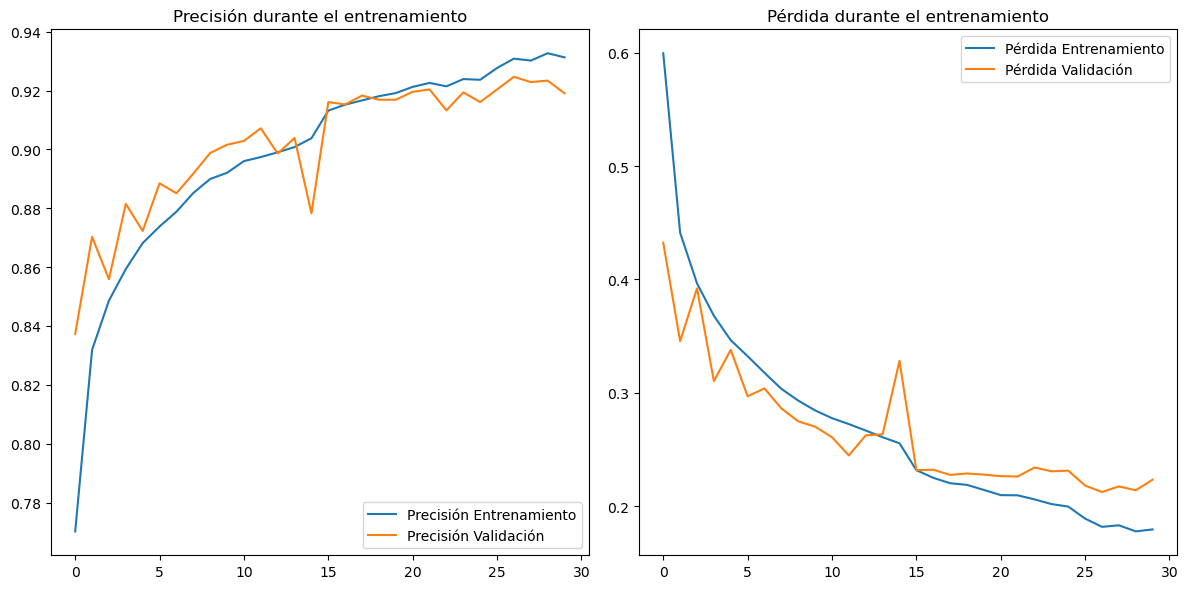

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9241 - loss: 0.2184
Precisión en el conjunto de prueba: 0.9247
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


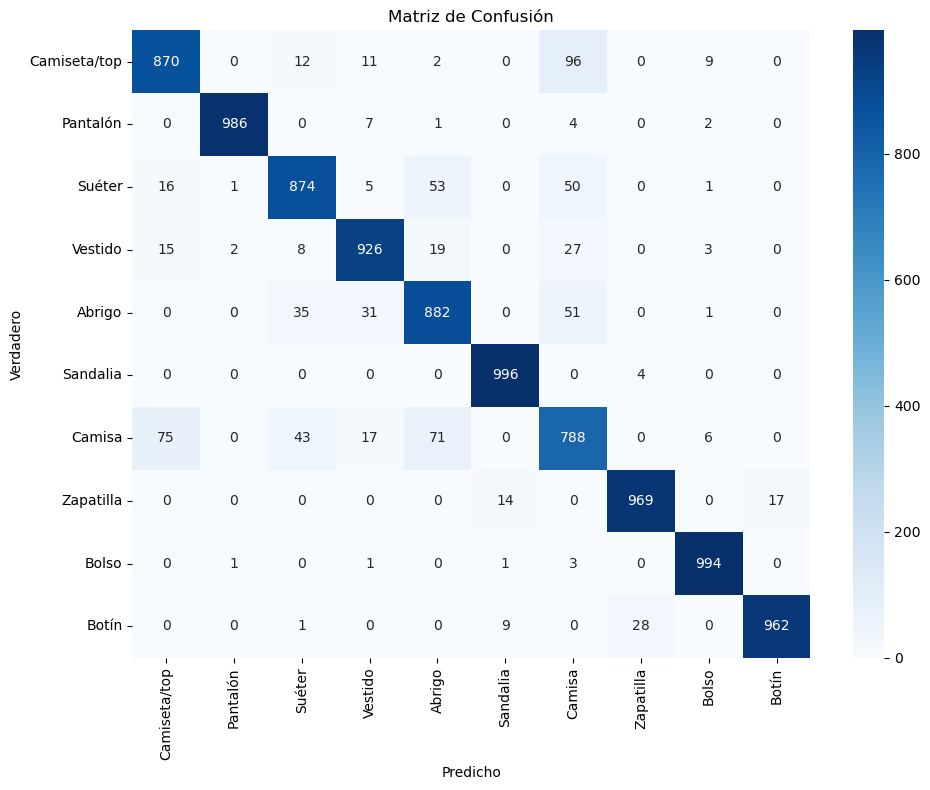

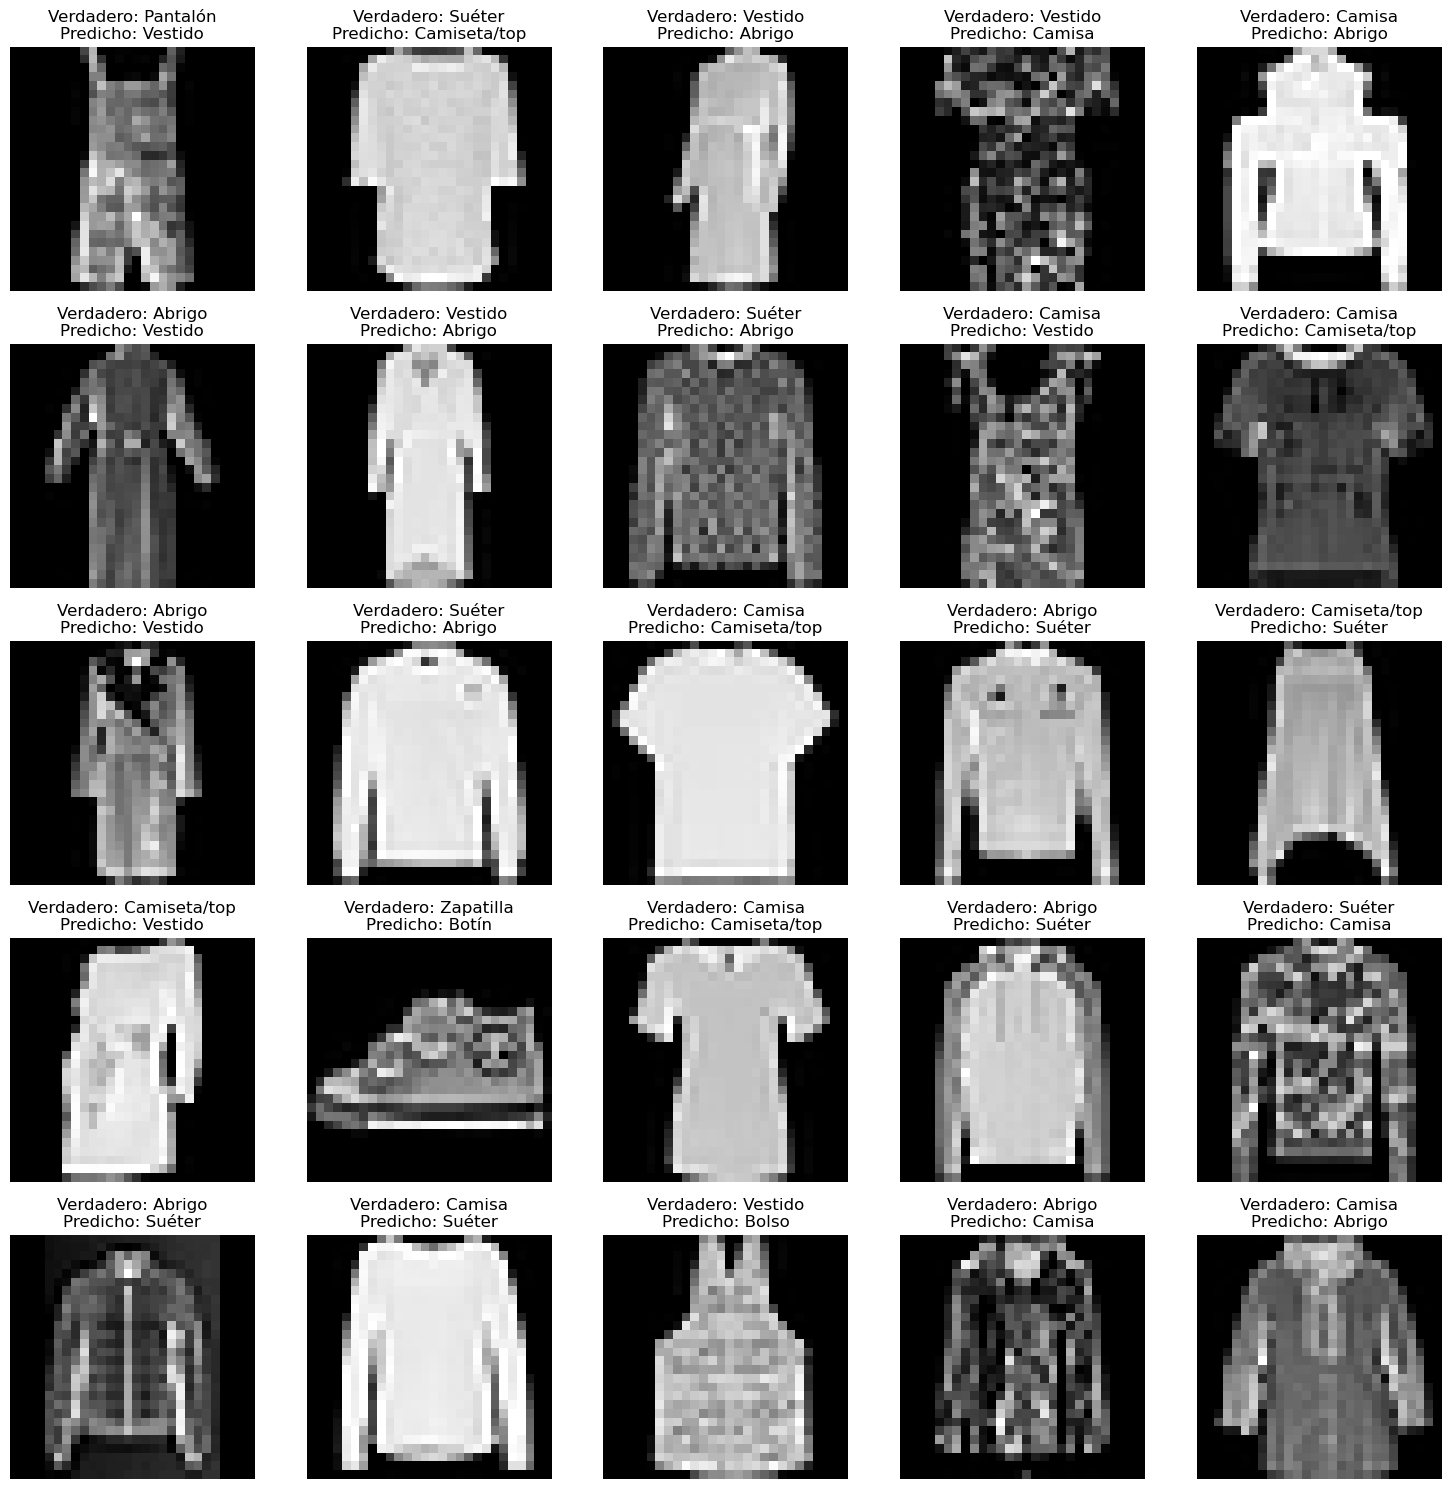

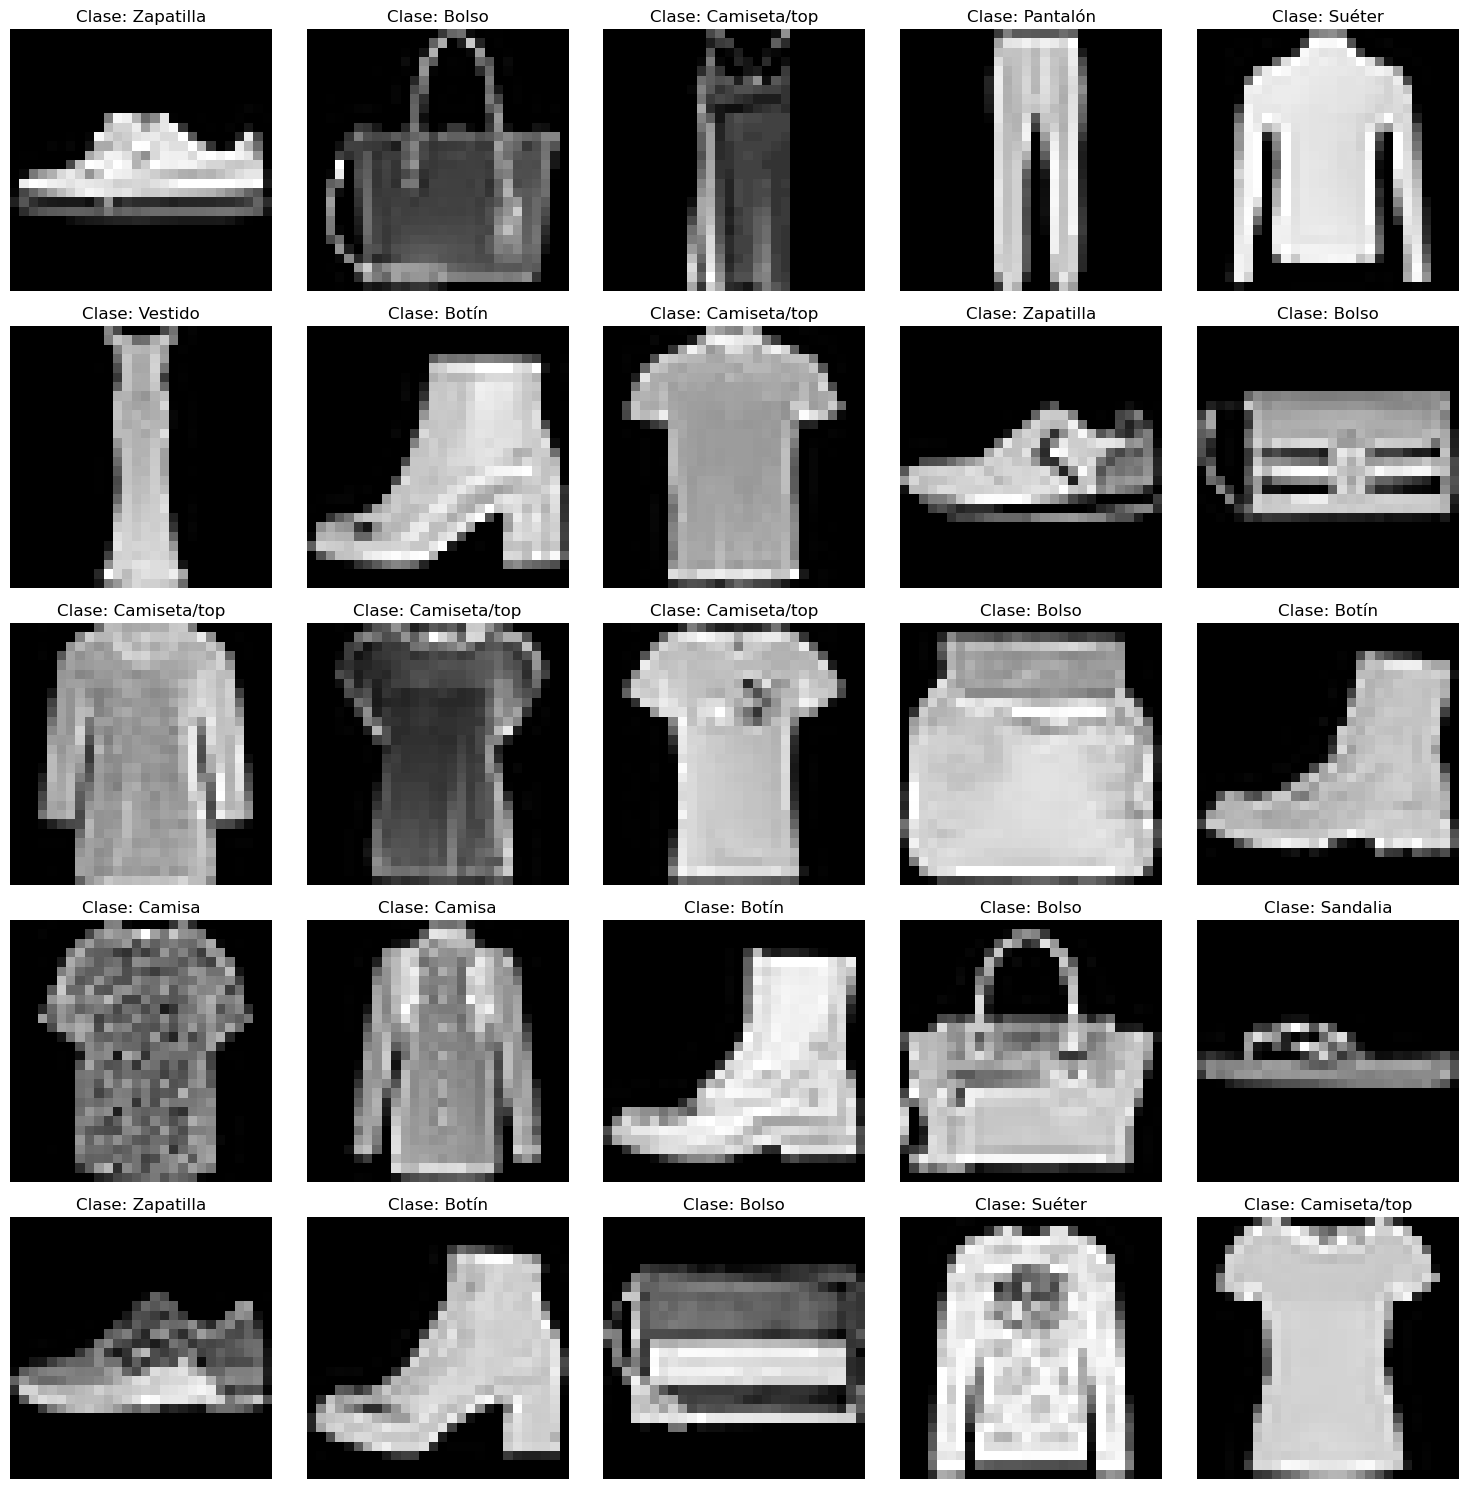

In [8]:
# Función para graficar la precisión y la pérdida
def plot_training_history(history):
    # Obtener los valores del historial
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Crear el gráfico de precisión
    epochs_range = range(len(acc))
    plt.figure(figsize=(12, 6))

    # Gráfico de precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Precisión Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Precisión Validación')
    plt.legend(loc='lower right')
    plt.title('Precisión durante el entrenamiento')

    # Gráfico de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida Validación')
    plt.legend(loc='upper right')
    plt.title('Pérdida durante el entrenamiento')

    plt.tight_layout()
    plt.show()

# Graficar los resultados del entrenamiento
plot_training_history(history)

# Evaluar el modelo en el conjunto de prueba y mostrar la precisión
test_loss, test_accuracy = efficientnet_model.evaluate(x_test, y_test_cat)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")

# Obtener predicciones
y_pred = efficientnet_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicho')
    plt.ylabel('Verdadero')
    plt.tight_layout()
    plt.show()

class_names = ['Camiseta/top', 'Pantalón', 'Suéter', 'Vestido', 'Abrigo',
               'Sandalia', 'Camisa', 'Zapatilla', 'Bolso', 'Botín']

# Graficar la matriz de confusión
plot_confusion_matrix(y_test, y_pred_classes, class_names)

# Función para visualizar imágenes mal clasificadas
def plot_misclassified_images(x_test, y_test, y_pred, class_names, num_images=25):
    misclassified = np.where(y_test != y_pred)[0]
    num_images = min(num_images, len(misclassified))
    
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(np.random.choice(misclassified, num_images, replace=False)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Verdadero: {class_names[y_test[idx]]}\nPredicho: {class_names[y_pred[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualizar imágenes mal clasificadas
plot_misclassified_images(x_test, y_test, y_pred_classes, class_names)

# Función para visualizar predicciones correctas
def plot_correct_predictions(x_test, y_test, y_pred, class_names, num_images=25):
    correct = np.where(y_test == y_pred)[0]
    num_images = min(num_images, len(correct))
    
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(np.random.choice(correct, num_images, replace=False)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Clase: {class_names[y_test[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualizar predicciones correctas
plot_correct_predictions(x_test, y_test, y_pred_classes, class_names)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


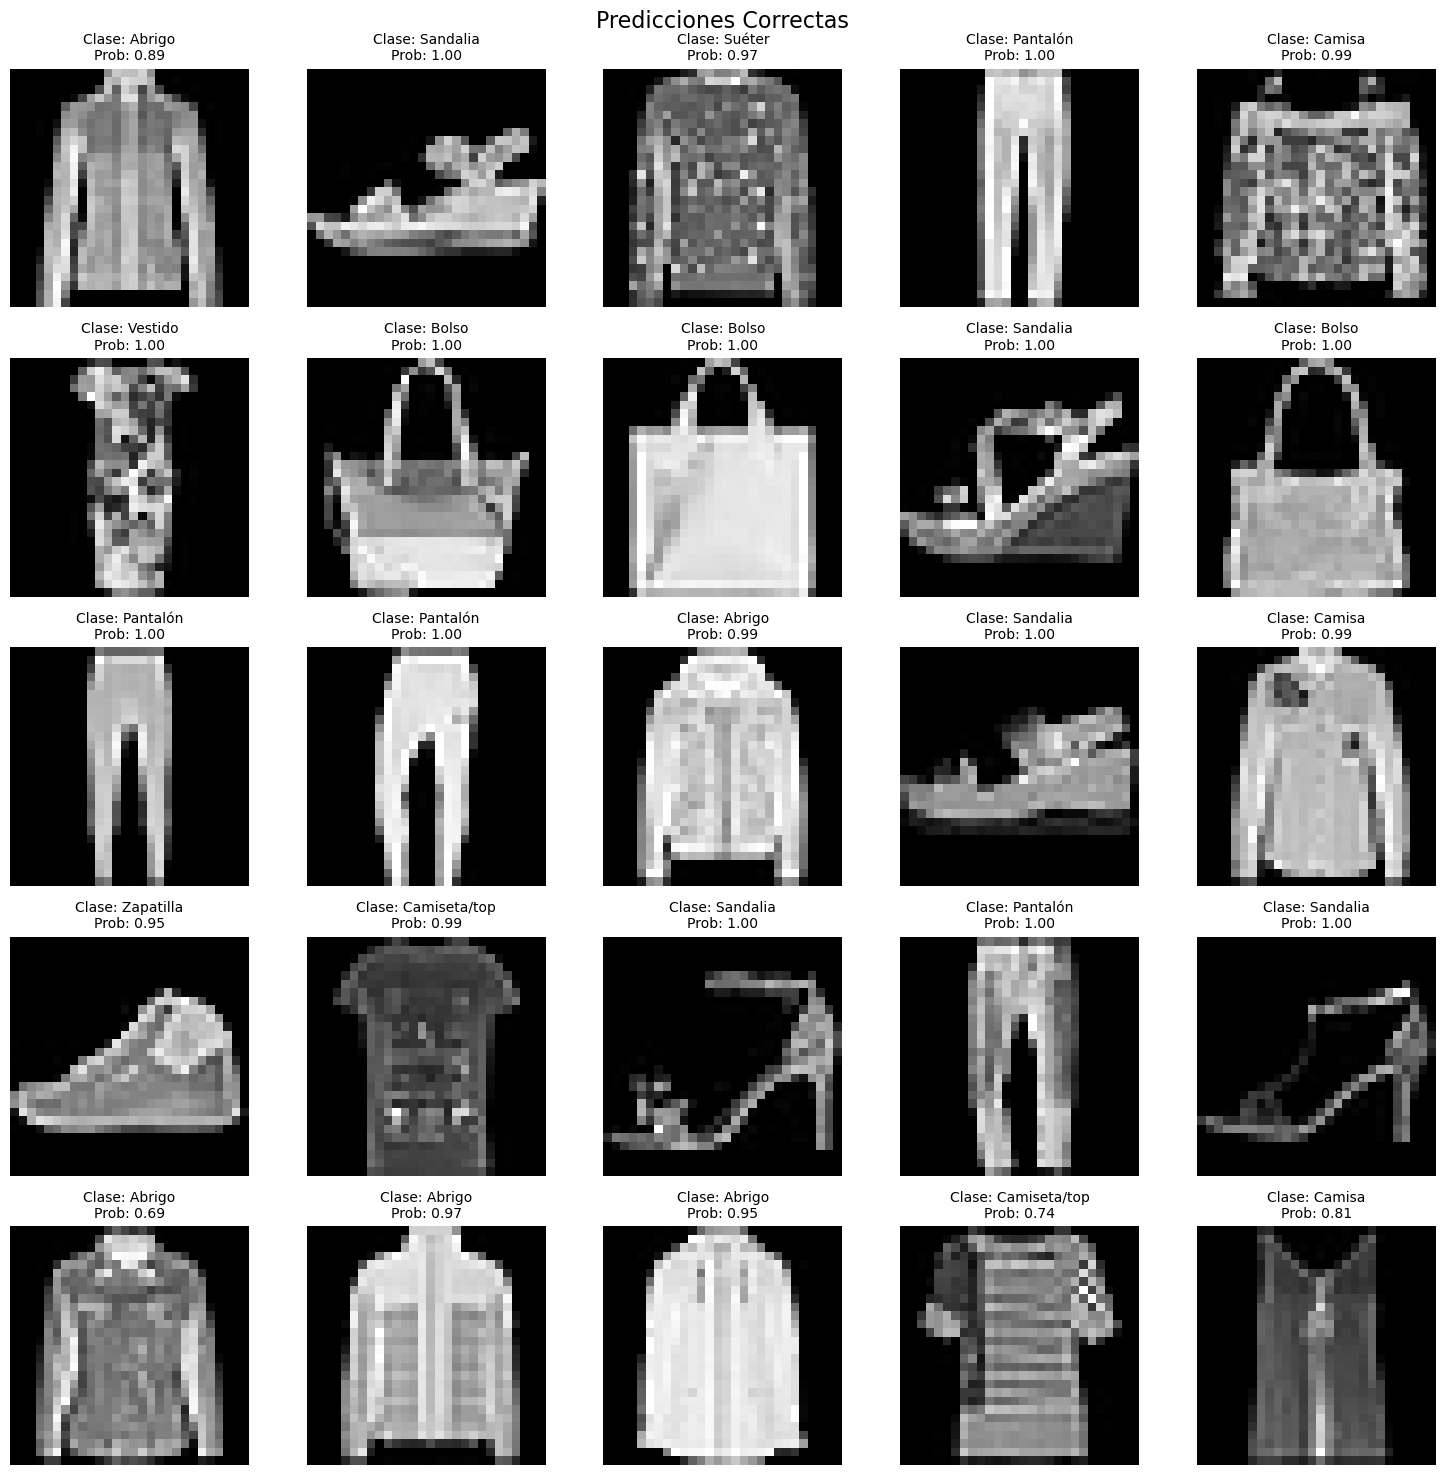

In [10]:
def plot_correct_predictions(x_test, y_test, y_pred, y_pred_proba, class_names, num_images=25, rows=5, cols=5):
    correct = np.where(y_test == y_pred)[0]  # Find correct predictions
    num_images = min(num_images, len(correct))  # Adjust num_images to available correct predictions
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    fig.suptitle("Predicciones Correctas", fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            idx = np.random.choice(correct)
            ax.imshow(x_test[idx].reshape(28, 28), cmap='gray')  # Assuming 28x28 image shape
            true_class = class_names[y_test[idx]]
            pred_prob = y_pred_proba[idx]  # Corrected: use 1D indexing
            ax.set_title(f"Clase: {true_class}\nProb: {pred_prob:.2f}", fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Obtener predicciones y probabilidades
y_pred = efficientnet_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_proba = np.max(y_pred, axis=1)

# Visualizar predicciones correctas
plot_correct_predictions(x_test, y_test, y_pred_classes, y_pred_proba, class_names, num_images=25, rows=5, cols=5)


In [14]:
# Evaluación del rendimiento en entrenamiento
print("\nEvaluación del rendimiento en entrenamiento:")
train_loss, train_accuracy = efficientnet_model.evaluate(x_train, y_train_cat, verbose=0)
print(f"Pérdida en entrenamiento: {train_loss:.4f}")
print(f"Precisión en entrenamiento: {train_accuracy:.4f}")

# Imprimir observaciones sobre tiempos y recursos
print(f"Número total de épocas entrenadas: {len(history.history['loss'])}")

# Check if 'time' exists in history.history and calculate average time
if 'time' in history.history and len(history.history['time']) > 0:
    avg_time = np.mean(history.history['time'])
    print(f"Tiempo promedio por época: {avg_time:.2f} segundos")

# Imprimir un resumen del modelo
print("\nResumen del modelo:")
efficientnet_model.summary()



Evaluación del rendimiento en entrenamiento:
Pérdida en entrenamiento: 0.1394
Precisión en entrenamiento: 0.9475
Número total de épocas entrenadas: 30

Resumen del modelo:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_5              │ (None, 14, 14, 32)     │           288 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_6              │ (None, 7, 7, 64)       │           576 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 128)      │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_7              │ (None, 4, 4, 128)      │         1,152 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │        32,768 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 956,320 (3.65 MB)

 Trainable params: 317,450 (1.21 MB)

 Non-trainable params: 3,968 (15.50 KB)

 Optimizer params: 634,902 (2.42 MB)